In [19]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from config import SEED, TOP_N_GENES, PCA_VARIANCE_THRESHOLD
from helpers import map_clinical_categories, print_model_report, clean_labels
from preprocessing import preprocess_clinical, drop_constant_columns
from pca import apply_pca
from train import split_data, train_models
from external_validation import run_external_validation
from imputation import knn_impute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pandas2ri.activate()
readRDS = robjects.r['readRDS']

In [3]:
r_obj = readRDS('data/UROMOL_TaLG.teachingcohort.rds')

# Drop 'exprs' column as before
colnames = list(r_obj.names)
clinical_cols = [name for name in colnames if name != 'exprs']
r_clinical = r_obj.rx(True, robjects.StrVector(clinical_cols))

# Convert to pandas
clinical_df = pandas2ri.rpy2py(r_clinical)

exprs_df = pd.read_csv('data/expr.csv', index_col=0)

In [4]:
# External Validation Dataset
external_val = readRDS('data/knowles_matched_TaLG_final.rds')

# Drop 'exprs' column as before
colnames = list(external_val.names)
clinical_cols = [name for name in colnames if name != 'exprs']
external_val = external_val.rx(True, robjects.StrVector(clinical_cols))

# Convert to pandas
external_clinical_df = pandas2ri.rpy2py(external_val)

external_expr = pd.read_csv('data/external_expr.csv', index_col=0)

In [5]:
cat_map = {
        'Sex': {'M': 0, 'F': 1},
        'Smoking': {'Never': 0, 'Former': 1, 'Current': 2},
        'Concomitant.CIS': {'No': 0, 'Yes': 1},
        'Incident.tumor': {'No': 0, 'Yes': 1},
        'Tumor.size': {'< 3 cm': 0, '>= 3 cm': 1},
        'EAU.risk': {'Low': 0, 'Intermediate': 1, 'High': 2},
        'UROMOL2021.classification': {'Class 1': 1, 'Class 2a': 4, 'Class 2b': 3, 'Class 3': 2}
    }

In [6]:
clinical_df = clean_labels(clinical_df)
clinical_df = map_clinical_categories(clinical_df, cat_map)
num_cols = ['Age', 'FUtime_days.']
cat_cols = [col for col in cat_map if col in clinical_df.columns]

/Users/hasti/University/UBC/Term 2/Problem-Based Learning in Bioinformatics/Assignments/4/Asnwer/helpers.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].astype(int)
/Users/hasti/University/UBC/Term 2/Problem-Based Learning in Bioinformatics/Assignments/4/Asnwer/helpers.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(mapping)
/Users/hasti/University/UBC/Term 2/Problem-Based Learning in Bioinformatics/Assignments/4/Asnwer/helpers.py:10: SettingWith

In [7]:
clinical_df, median_vals, mode_vals = preprocess_clinical(clinical_df, num_cols, cat_cols)
clinical_df = drop_constant_columns(clinical_df)

In [8]:
print("Missing values per column in clinical_df:")
print(clinical_df.isnull().sum()[clinical_df.isnull().sum() > 0])

Missing values per column in clinical_df:
PFS_time.    1
dtype: int64


In [9]:
feature_col = ['Age', 'Sex', 'Smoking', 'Concomitant.CIS', 'Tumor.size', 'Incident.tumor', 'EAU.risk', 'BCG', 'UROMOL2021.classification']
label_col = ['Recurrence']

In [10]:
exprs_top_df = exprs_df.loc[clinical_df.index]
TOP_N_GENES = 250
PCA_VARIANCE_THRESHOLD = 0.75
pca_df, pca_model, scaler, top_genes = apply_pca(exprs_top_df, top_n=TOP_N_GENES, variance_threshold=PCA_VARIANCE_THRESHOLD)

full_df = clinical_df[feature_col + label_col].join(pca_df)
full_df.columns = full_df.columns.astype(str)

X = full_df.drop(columns='Recurrence')
y = full_df['Recurrence']

# X = clinical_df[feature_col]
# y = clinical_df['Recurrence']

# X = pca_df
# y = clinical_df['Recurrence']


X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

models = train_models(X_train, y_train, n_estimators=40, max_depth=2)

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print_model_report(f"{name} (Internal)", y_test, y_pred, y_proba)


📊 LogisticRegression (Internal) Evaluation
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        17
           1       0.79      0.79      0.79        39

    accuracy                           0.71        56
   macro avg       0.66      0.66      0.66        56
weighted avg       0.71      0.71      0.71        56

AUC: 0.717948717948718

📊 RandomForest (Internal) Evaluation
              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.81      0.87      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.70      0.71        56
weighted avg       0.76      0.77      0.76        56

AUC: 0.7104072398190046

📊 XGBoost (Internal) Evaluation
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        17
           1       0.80      0.90      0.84        39

    accuracy        

In [11]:
cat_map = {
    'Sex': {'M': 0, 'F': 1},
    'Smoking': {'Never': 0, 'Former': 1, 'Current': 2},
    'Concomitant.CIS': {'No': 0, 'Yes': 1},
    'Incident.tumor': {'No': 0, 'Yes': 1},
    'Tumor.size': {'< 3 cm': 0, '>= 3 cm': 1},
    'EAU.risk': {'Low': 0, 'Intermediate': 1, 'High': 2},
    'UROMOL2021.classification': {'Class_1': 1, 'Class_2a': 4, 'Class_2b': 3, 'Class_3': 2}
}

external_clinical_df = map_clinical_categories(external_clinical_df, cat_map)


clincal_col_feature = [i for i in external_clinical_df.columns if i in feature_col]
expr_columns_top_n = [i for i in external_expr.columns if i in top_genes]

comb_feature = clincal_col_feature + expr_columns_top_n


external_clinical_df, external_expr = knn_impute(external_clinical_df, external_expr, clinical_df, exprs_df, comb_feature, feature_col, top_genes, cat_cols)

num_cols = [i for i in num_cols if i in comb_feature]
cat_cols = [i for i in cat_cols if i in comb_feature]

external_clinical_df, _, _ = preprocess_clinical(external_clinical_df, num_cols, cat_cols, median_vals, mode_vals)

external_expr = external_expr[top_genes]
external_clinical_df = external_clinical_df[feature_col + label_col]


# Replace invalid value with NaN
external_clinical_df['Recurrence'] = external_clinical_df['Recurrence'].replace(-2147483648, np.nan)

# Drop rows with missing labels
external_clinical_df = external_clinical_df.dropna(subset=['Recurrence'])

# Convert to int (just in case)
external_clinical_df['Recurrence'] = external_clinical_df['Recurrence'].astype(int)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have vali

In [12]:
print("Missing values per column in clinical_df:")
print(external_expr.isnull().sum()[external_expr.isnull().sum() > 0])

Missing values per column in clinical_df:
Series([], dtype: int64)


In [13]:
external_pca_df = pd.DataFrame(pca_model.transform(external_expr), index=external_expr.index,
                                columns=[f'PC{i+1}' for i in range(pca_model.n_components_)])

external_df_final = external_clinical_df[X.columns.intersection(external_clinical_df.columns)].join(external_pca_df)
y_true_ext = external_clinical_df.loc[external_df_final.index, 'Recurrence']

external_clinical_df.columns = external_clinical_df.columns.astype(str)
external_df_final.columns = external_df_final.columns.astype(str)

run_external_validation(models, external_df_final, y_true_ext)
# run_external_validation(models, external_clinical_df[feature_col], external_clinical_df['Recurrence'])
# run_external_validation(models, external_pca_df.loc[external_df_final.index], y_true_ext)


📊 LogisticRegression (External) Evaluation
              precision    recall  f1-score   support

           0       0.75      0.07      0.12        44
           1       0.41      0.97      0.57        29

    accuracy                           0.42        73
   macro avg       0.58      0.52      0.35        73
weighted avg       0.61      0.42      0.30        73

AUC: 0.6434169278996865

📊 RandomForest (External) Evaluation
              precision    recall  f1-score   support

           0       0.64      0.86      0.74        44
           1       0.57      0.28      0.37        29

    accuracy                           0.63        73
   macro avg       0.61      0.57      0.55        73
weighted avg       0.62      0.63      0.59        73

AUC: 0.5740595611285266

📊 XGBoost (External) Evaluation
              precision    recall  f1-score   support

           0       0.62      0.55      0.58        44
           1       0.41      0.48      0.44        29

    accuracy       

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [14]:
print("Top 10 genes by variance:")
print(exprs_df.var().sort_values(ascending=False).head(10))

print("Number of PCA components kept:")
print(pca_model.n_components_)


Top 10 genes by variance:
RN7SK                         45.697692
RN7SL1                        28.667763
LncRNA5978_ENSG00000280800    24.265657
LncRNA6003_ENSG00000281181    24.265573
LncRNA5967_ENSG00000280614    24.265166
LncRNA6013_ENSG00000281383    20.527122
XIST                          20.035462
GSTM1                         18.061941
LncRNA1620_ENSG00000240801    17.197436
HSPA1A                        16.210850
dtype: float64
Number of PCA components kept:
44


UROMOL2021.classification    0.219035
Smoking                      0.165749
PC32                        -0.109986
PC33                         0.105481
EAU.risk                     0.098790
PC26                         0.095932
PC15                        -0.079249
PC6                          0.072301
PC38                        -0.061467
PC30                         0.057066
PC27                        -0.055733
PC18                         0.054807
PC8                         -0.053638
PC25                        -0.044974
PC10                        -0.043696
dtype: float64
PC6     0.093165
PC38    0.075650
PC8     0.059835
PC32    0.056471
PC15    0.048914
PC11    0.048295
PC24    0.038956
PC18    0.038423
PC26    0.036541
PC14    0.035256
PC10    0.025472
PC30    0.024892
PC29    0.024027
PC9     0.022911
PC33    0.021041
dtype: float64


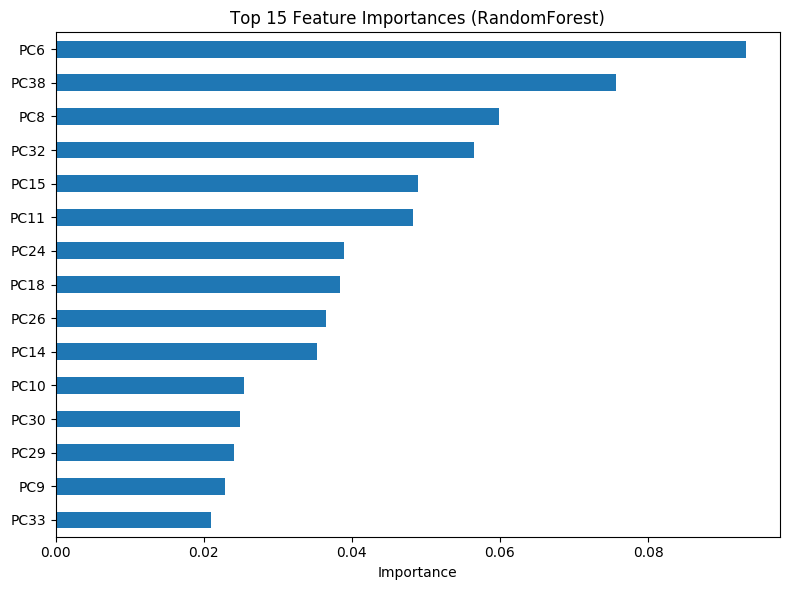

In [22]:
for name, model in models.items():
    if name == 'LogisticRegression':
        lr_coef = pd.Series(model.coef_[0], index=X_train.columns)
        print(lr_coef.sort_values(key=abs, ascending=False).head(15))

    if name == 'RandomForest':
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        top_features = importances.sort_values(ascending=False).head(15)
        print(top_features)


        top_features.plot(kind='barh', figsize=(8, 6), title="Top 15 Feature Importances (RandomForest)")
        plt.gca().invert_yaxis()
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

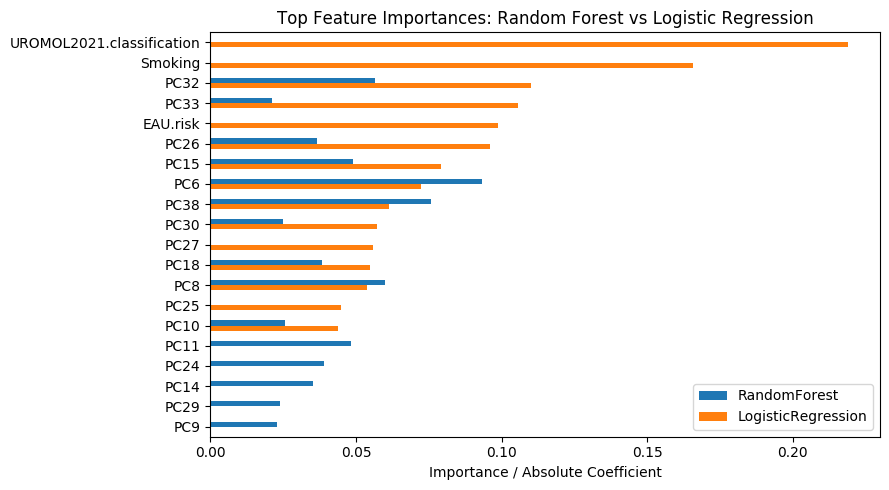

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract top features from both models
rf_importance = None
lr_coef = None

for name, model in models.items():
    if name == 'LogisticRegression':
        lr_coef = pd.Series(model.coef_[0], index=X_train.columns)
        lr_coef = lr_coef.abs().sort_values(ascending=False).head(15)

    if name == 'RandomForest':
        rf_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        rf_importance = rf_importance.sort_values(ascending=False).head(15)

# Combine into one DataFrame (only features that appear in either top list)
combined_features = list(set(rf_importance.index).union(set(lr_coef.index)))
combined_df = pd.DataFrame(index=combined_features)
combined_df['RandomForest'] = rf_importance
combined_df['LogisticRegression'] = lr_coef

# sort first logistic and then randomforest
combined_df = combined_df.sort_values(by=['LogisticRegression', 'RandomForest'], ascending=False)

# Plot
combined_df.plot(kind='barh', figsize=(9,5), title='Top Feature Importances: Random Forest vs Logistic Regression')
plt.xlabel("Importance / Absolute Coefficient")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

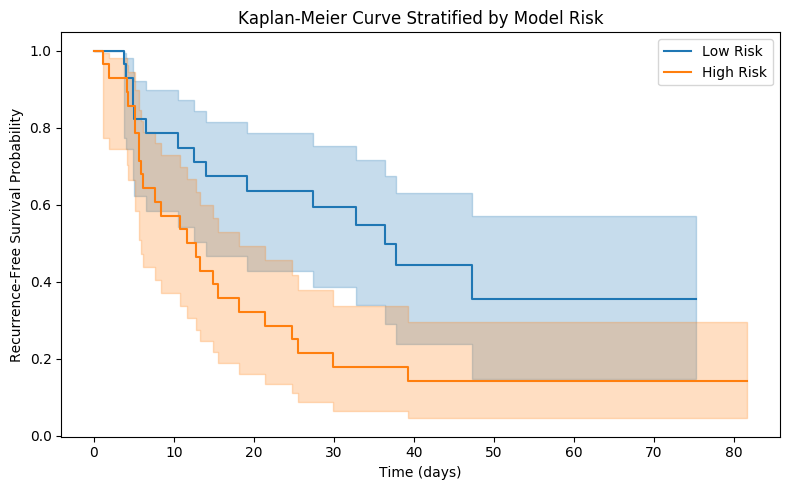

In [29]:
# Assuming you used Logistic Regression for this
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities
y_proba = models['LogisticRegression'].predict_proba(X_test)[:, 1]

# Define high-risk and low-risk groups by threshold (e.g., median)
threshold = np.median(y_proba)
risk_group = (y_proba > threshold).astype(int)

# RFS times and event status
rfs_time = clinical_df.loc[X_test.index, 'RFS_time']
recurrence = clinical_df.loc[X_test.index, 'Recurrence']

# Plot
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))

for label in [0, 1]:
    mask = risk_group == label
    group_name = 'Low Risk' if label == 0 else 'High Risk'
    kmf.fit(rfs_time[mask], event_observed=recurrence[mask], label=group_name)
    kmf.plot(ci_show=True)

plt.title('Kaplan-Meier Curve Stratified by Model Risk')
plt.xlabel('Time (days)')
plt.ylabel('Recurrence-Free Survival Probability')
plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_proba)
print("AUC:", auc)

AUC: 0.717948717948718


In [32]:
from lifelines.utils import concordance_index

rfs_time = clinical_df.loc[X_test.index, 'RFS_time']
recurrence = clinical_df.loc[X_test.index, 'Recurrence']

c_index = concordance_index(rfs_time, -y_proba, recurrence)  # Use -y_proba since higher risk = sooner event
print("C-index:", c_index)


C-index: 0.6275964391691394


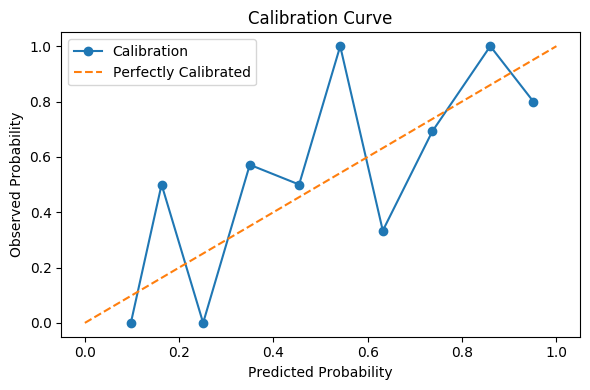

In [33]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()

The calibration curve compares the predicted probabilities of recurrence generated by the classifier with the actual observed recurrence rates in the test set. A perfectly calibrated model would fall along the diagonal reference line, where predicted risk matches observed outcomes.

In this case, the calibration plot shows some variability across bins, especially in the lower and middle probability ranges, where the model tends to underestimate recurrence risk in some intervals and overestimate it in others. However, the general trend suggests that the model captures the overall likelihood of recurrence with reasonable consistency, particularly in the higher risk probabilities where predictions align more closely with observed outcomes.

While not perfectly calibrated, the model demonstrates sufficient calibration to support its use in guiding clinical decision-making, especially when combined with threshold-based risk stratification or post-processing adjustments such as isotonic regression or Platt scaling.

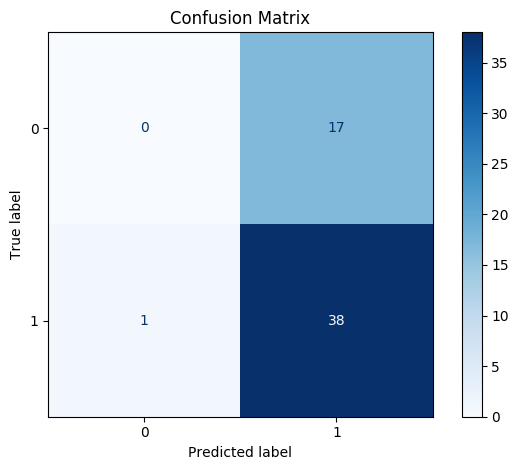

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
